实验环境信息等内容网址：

repo: [Streamer0320/NLP-3b | GitHub](https://github.com/Streamer0320/NLP-3b/)

fork: [jin-hao-0320/NLP-3b | Gitee](https://gitee.com/jin-hao-0320/NLP-3b)

# 7. 从文本提取信息

对于任何给定的问题，很可能已经有人把答案写在某个地方了。以电子形式提供的自然语言文本的数量真的惊人，并且与日俱增。然而，自然语言的复杂性使访问这些文本中的信息非常困难。NLP目前的技术水平仍然有很长的路要走才能够从不受限制的文本对意义建立通用的表示。如果我们不是集中我们的精力在问题或“实体关系”的有限集合，例如：“不同的设施位于何处”或“谁被什么公司雇用”上，我们就能取得重大进展。本章的目的是要回答下列问题：

1. 我们如何能构建一个系统，从非结构化文本中提取结构化数据如表格？
2. 有哪些稳健的方法识别一个文本中描述的实体和关系？
3. 哪些语料库适合这项工作，我们如何使用它们来训练和评估我们的模型？

一路上，我们将应用前面两章中的技术来解决分块和命名实体识别。

<a href="#1-信息提取">1 信息提取</a> 

<a href="#2-词块划分">2 词块划分</a> 

<a href="#3-开发和评估词块划分器">3 开发和评估词块划分器</a> 

<a href="#4-语言结构中的递归">4 语言结构中的递归</a> 

<a href="#5-命名实体识别">5 命名实体识别</a> 

<a href="#6-关系抽取">6 关系抽取</a> 

<a href="#7-小结">7 小结</a> 

<a href="#8-深入阅读">8 深入阅读</a> 

<a href="#9-练习">9 练习</a> 


## 1 信息提取

信息有很多种形状和大小。一个重要的形式是结构化数据：实体和关系的可预测的规范的结构。例如，我们可能对公司和地点之间的关系感兴趣。给定一个公司，我们希望能够确定它做业务的位置；反过来，给定位置，我们会想发现哪些公司在该位置做业务。如果我们的数据是表格形式，如[1.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#tab-db-locations)中的例子，那么回答这些问题就很简单了。

表 1.1：

位置数据

In [1]:
locs = [('Omnicom', 'IN', 'New York'),
        ('DDB Needham', 'IN', 'New York'),
        ('Kaplan Thaler Group', 'IN', 'New York'),
        ('BBDO South', 'IN', 'Atlanta'),
        ('Georgia-Pacific', 'IN', 'Atlanta')]
query = [e1 for (e1, rel, e2) in locs if e2=='Atlanta']
print(query)

['BBDO South', 'Georgia-Pacific']


表 1.2：

在亚特兰大运营的公司

In [2]:
def ie_preprocess(document):
   sentences = nltk.sent_tokenize(document) 
   sentences = [nltk.word_tokenize(sent) for sent in sentences] 
   sentences = [nltk.pos_tag(sent) for sent in sentences] 

注意

请记住我们的例子程序假设你以`import nltk, re, pprint`开始交互式会话或程序。

接下来，命名实体识别中，我们分割和标注可能组成一个有趣关系的实体。通常情况下，这些将被定义为名词短语，例如the knights who say "ni"或者适当的名称如Monty Python。在一些任务中，同时考虑不明确的名词或名词块也是有用的，如every student或cats，这些不必要一定与确定的`NP`s和适当名称一样的方式指示实体。

最后，在提取关系时，我们搜索对文本中出现在附近的实体对之间的特殊模式，并使用这些模式建立元组记录实体之间的关系。

## 2 词块划分

我们将用于实体识别的基本技术是词块划分，它分割和标注多词符的序列，如[2.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#fig-chunk-segmentation)所示。小框显示词级分词和词性标注，大框显示高级别的词块划分。每个这种较大的框叫做一个词块。就像分词忽略空白符，词块划分通常选择词符的一个子集。同样像分词一样，词块划分器生成的片段在源文本中不能重叠。

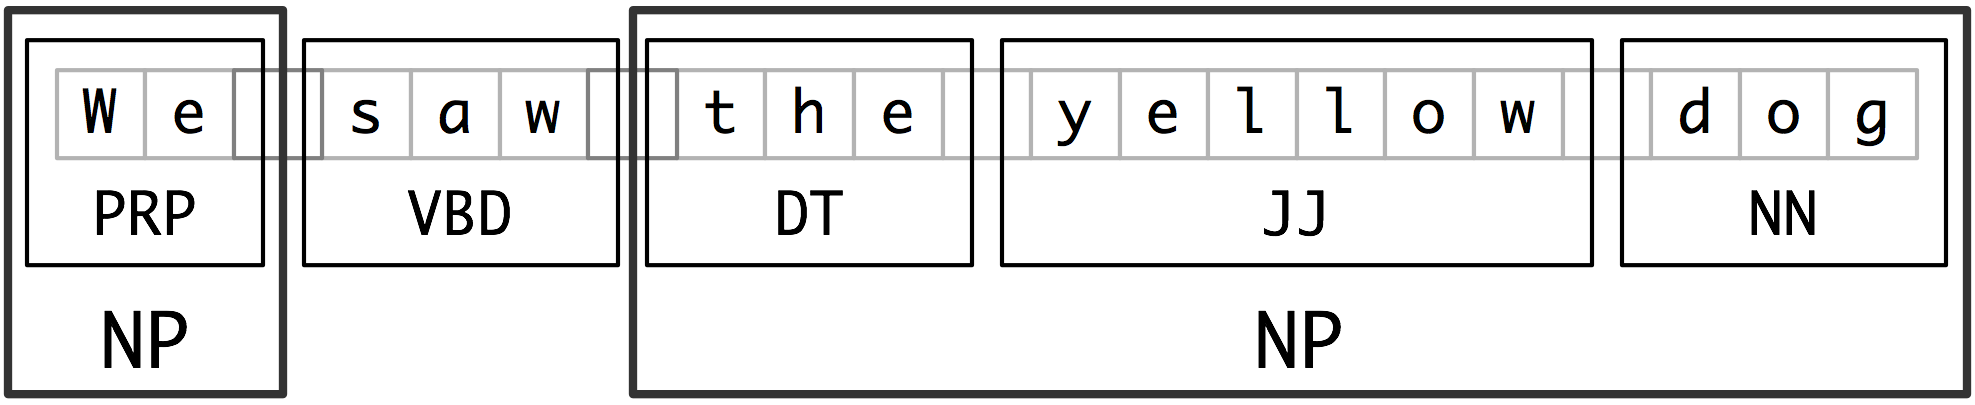

图 2.1：词符和词块级别的分割与标注

在本节中，我们将在较深的层面探讨词块划分，以词块的定义和表示开始。我们将看到正则表达式和N-gram的方法来词块划分，使用CoNLL-2000词块划分语料库开发和评估词块划分器。我们将在[(5)](https://usyiyi.github.io/nlp-py-2e-zh/7.html#sec-ner)和[6](https://usyiyi.github.io/nlp-py-2e-zh/7.html#sec-relextract)回到命名实体识别和关系抽取的任务。

jupyter notebook

<a href="#2.1-名词短语词块划分">2.1 名词短语词块划分</a> 

<a href="#2.2-标记模式">2.2 标记模式</a> 

<a href="#2.3-用正则表达式进行词块划分">2.3 用正则表达式进行词块划分</a> 

<a href="#2.4-探索文本语料库">2.4 探索文本语料库</a> 

<a href="#2.5-词缝加塞">2.5 词缝加塞</a> 

<a href="#2.6-词块的表示:标记与树">2.6 词块的表示:标记与树</a> 

vscode jupyter

<a href="#21-名词短语词块划分">2.1 名词短语词块划分</a> 

<a href="#22-标记模式">2.2 标记模式</a> 

<a href="#23-用正则表达式进行词块划分">2.3 用正则表达式进行词块划分</a> 

<a href="#24-探索文本语料库">2.4 探索文本语料库</a> 

<a href="#25-词缝加塞">2.5 词缝加塞</a> 

<a href="#26-词块的表示:标记与树">2.6 词块的表示:标记与树</a> 

## 2.1 名词短语词块划分

我们将首先思考名词短语词块划分或NP词块划分任务，在那里我们寻找单独名词短语对应的词块。例如，这里是一些《华尔街日报》文本，其中的`NP`词块用方括号标记：

In [4]:
import nltk

sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"), 
("dog", "NN"), ("barked", "VBD"), ("at", "IN"),  ("the", "DT"), ("cat", "NN")]

grammar = "NP: {<DT>?<JJ>*<NN>}" 

cp = nltk.RegexpParser(grammar) 
result = cp.parse(sentence) 
print(result) 

(S
  (NP the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP the/DT cat/NN))


In [5]:
result.draw() # 这里会生成一个窗口

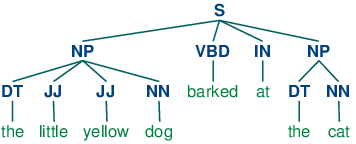

## 2.2 标记模式

组成一个词块语法的规则使用标记模式来描述已标注的词的序列。一个标记模式是一个词性标记序列，用尖括号分隔，如`<DT>?<JJ>*<NN>`。标记模式类似于正则表达式模式（[3.4](https://usyiyi.github.io/nlp-py-2e-zh/3.html#sec-regular-expressions-word-patterns)）。现在，思考下面的来自《华尔街日报》的名词短语：

> another/DT sharp/JJ dive/NN
trade/NN figures/NNS
any/DT new/JJ policy/NN measures/NNS
earlier/JJR stages/NNS
Panamanian/JJ dictator/NN Manuel/NNP Noriega/NNP

## 2.3 用正则表达式进行词块划分

要找到一个给定的句子的词块结构，`RegexpParser`词块划分器以一个没有词符被划分的平面结构开始。词块划分规则轮流应用，依次更新词块结构。一旦所有的规则都被调用，返回生成的词块结构。

[2.3](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-chunker1)显示了一个由2个规则组成的简单的词块语法。第一条规则匹配一个可选的限定词或所有格代名词，零个或多个形容词，然后跟一个名词。第二条规则匹配一个或多个专有名词。我们还定义了一个进行词块划分的例句 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-chunker1-ex)，并在此输入上运行这个词块划分器 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-chunker1-run)。

In [6]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
      {<NNP>+}                # chunk sequences of proper nouns
"""
cp = nltk.RegexpParser(grammar)
sentence = [("Rapunzel", "NNP"), ("let", "VBD"), ("down", "RP"), 
                 ("her", "PP$"), ("long", "JJ"), ("golden", "JJ"), ("hair", "NN")]

注意

`$`符号是正则表达式中的一个特殊字符，必须使用反斜杠转义来匹配`PP$`标记。

如果标记模式匹配位置重叠，最左边的匹配优先。例如，如果我们应用一个匹配两个连续的名词文本的规则到一个包含三个连续的名词的文本，则只有前两个名词将被划分：

In [7]:
nouns = [("money", "NN"), ("market", "NN"), ("fund", "NN")]
grammar = "NP: {<NN><NN>}  # Chunk two consecutive nouns"
cp = nltk.RegexpParser(grammar)
print(cp.parse(nouns))

(S (NP money/NN market/NN) fund/NN)


一旦我们创建了money market词块，我们就已经消除了允许fund被包含在一个词块中的上下文。这个问题可以避免，使用一种更加宽容的块规则，如`NP: {<NN>+}`。

注意

我们已经为每个块规则添加了一个注释。这些是可选的；当它们的存在时，词块划分器将它作为其跟踪输出的一部分输出这些注释。

## 2.4 探索文本语料库

在[2](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-tagged-corpora)中，我们看到了我们如何在已标注的语料库中提取匹配的特定的词性标记序列的短语。我们可以使用词块划分器更容易的做同样的工作，如下：

In [8]:
cp = nltk.RegexpParser('CHUNK: {<V.*> <TO> <V.*>}')
brown = nltk.corpus.brown
for sent in brown.tagged_sents():
    tree = cp.parse(sent)
    for subtree in tree.subtrees():
        if subtree.label() == 'CHUNK': print(subtree)

(CHUNK combined/VBN to/TO achieve/VB)
(CHUNK continue/VB to/TO place/VB)
(CHUNK serve/VB to/TO protect/VB)
(CHUNK wanted/VBD to/TO wait/VB)
(CHUNK allowed/VBN to/TO place/VB)
(CHUNK expected/VBN to/TO become/VB)
(CHUNK expected/VBN to/TO approve/VB)
(CHUNK expected/VBN to/TO make/VB)
(CHUNK intends/VBZ to/TO make/VB)
(CHUNK seek/VB to/TO set/VB)
(CHUNK like/VB to/TO see/VB)
(CHUNK designed/VBN to/TO provide/VB)
(CHUNK get/VB to/TO hear/VB)
(CHUNK expects/VBZ to/TO tell/VB)
(CHUNK expected/VBN to/TO give/VB)
(CHUNK prefer/VB to/TO pay/VB)
(CHUNK required/VBN to/TO obtain/VB)
(CHUNK permitted/VBN to/TO teach/VB)
(CHUNK designed/VBN to/TO reduce/VB)
(CHUNK Asked/VBN to/TO elaborate/VB)
(CHUNK got/VBN to/TO go/VB)
(CHUNK raised/VBN to/TO pay/VB)
(CHUNK scheduled/VBN to/TO go/VB)
(CHUNK cut/VBN to/TO meet/VB)
(CHUNK needed/VBN to/TO meet/VB)
(CHUNK hastened/VBD to/TO add/VB)
(CHUNK found/VBN to/TO prevent/VB)
(CHUNK continue/VB to/TO insist/VB)
(CHUNK compelled/VBN to/TO make/VB)
(CHUNK mad

(CHUNK begins/VBZ to/TO notice/VB)
(CHUNK expected/VBN to/TO win/VB)
(CHUNK seek/VB to/TO find/VB)
(CHUNK join/VB to/TO defeat/VB)
(CHUNK meant/VBN to/TO repeat/VB)
(CHUNK trying/VBG to/TO downgrade/VB)
(CHUNK tried/VBD to/TO guard/VB)
(CHUNK want/VB to/TO separate/VB)
(CHUNK seem/VB to/TO indicate/VB)
(CHUNK afford/VB to/TO buy/VB)
(CHUNK try/VB to/TO develop/VB)
(CHUNK attempting/VBG to/TO attract/VB)
(CHUNK compelled/VBN to/TO write/VB)
(CHUNK failed/VBN to/TO set/VB)
(CHUNK continue/VB to/TO shape/VB)
(CHUNK wants/VBZ to/TO study/VB)
(CHUNK wants/VBZ to/TO study/VB)
(CHUNK equipped/VBN to/TO care/VB)
(CHUNK expected/VBN to/TO survive/VB)
(CHUNK shocked/VBN to/TO see/VB)
(CHUNK going/VBG to/TO play/VB)
(CHUNK voted/VBN to/TO aid/VB)
(CHUNK died/VBD to/TO uphold/VB)
(CHUNK urged/VBN to/TO reduce/VB)
(CHUNK wish/VB to/TO state/VB)
(CHUNK expected/VBN to/TO give/VB)
(CHUNK trying/VBG to/TO maintain/VB)
(CHUNK attempt/VB to/TO seek/VB)
(CHUNK wishes/VBZ to/TO commend/VB)
(CHUNK qualifie

(CHUNK continue/VB to/TO release/VB)
(CHUNK wish/VB to/TO create/VB)
(CHUNK trim/VB to/TO fit/VB)
(CHUNK cut/VBN to/TO fit/VB)
(CHUNK help/VB to/TO prevent/VB)
(CHUNK designed/VBN to/TO take/VB)
(CHUNK used/VBN to/TO transport/VB)
(CHUNK want/VB to/TO buy/VB)
(CHUNK used/VBN to/TO fasten/VB)
(CHUNK help/VB to/TO keep/VB)
(CHUNK needed/VBN to/TO build/VB)
(CHUNK designed/VBN to/TO accommodate/VB)
(CHUNK adjusted/VBN to/TO suit/VB)
(CHUNK used/VBN to/TO cut/VB)
(CHUNK want/VB to/TO avoid/VB)
(CHUNK agreed/VBN to/TO take/VB)
(CHUNK planned/VBD to/TO destroy/VB)
(CHUNK allowed/VBN to/TO issue/VB)
(CHUNK managed/VBD to/TO coerce/VB)
(CHUNK want/VB to/TO know/VB)
(CHUNK planning/VBG to/TO bring/VB)
(CHUNK urged/VBN to/TO keep/VB)
(CHUNK come/VB to/TO swim/VB)
(CHUNK enjoined/VBN to/TO look/VB)
(CHUNK prepared/VBN to/TO cope/VB)
(CHUNK want/VB to/TO make/VB)
(CHUNK allowed/VBN to/TO dry/VB)
(CHUNK pays/VBZ to/TO buy/VB)
(CHUNK want/VB to/TO play/VB)
(CHUNK expected/VBN to/TO last/VB)
(CHUNK p

(CHUNK inclined/VBN to/TO remain/VB)
(CHUNK heard/VBN to/TO say/VB)
(CHUNK stopped/VBN to/TO receive/VB)
(CHUNK used/VBN to/TO describe/VB)
(CHUNK claimed/VBD to/TO own/VB)
(CHUNK tried/VBD to/TO find/VB)
(CHUNK meant/VBD to/TO pay/VB)
(CHUNK given/VBN to/TO go/VB)
(CHUNK wanted/VBD to/TO make/VB)
(CHUNK began/VBD to/TO gallop/VB)
(CHUNK attempting/VBG to/TO lasso/VB)
(CHUNK failing/VBG to/TO encircle/VB)
(CHUNK got/VBN to/TO get/VB)
(CHUNK trying/VBG to/TO maneuver/VB)
(CHUNK beginning/VBG to/TO go/VB)
(CHUNK began/VBD to/TO pull/VB)
(CHUNK began/VBD to/TO draw/VB)
(CHUNK like/VB to/TO go/VB)
(CHUNK tend/VB to/TO compete/VB)
(CHUNK doing/VBG to/TO help/VB)
(CHUNK begins/VBZ to/TO see/VB)
(CHUNK Desiring/VBG to/TO fill/VB)
(CHUNK tends/VBZ to/TO look/VB)
(CHUNK try/VB to/TO match/VB)
(CHUNK played/VBN to/TO win/VB)
(CHUNK failed/VBD to/TO make/VB)
(CHUNK began/VBD to/TO involve/VB)
(CHUNK learning/VBG to/TO bunt/VB)
(CHUNK dared/VBD to/TO dream/VB)
(CHUNK dared/VBD to/TO taunt/VB)
(CHU

(CHUNK made/VBN to/TO integrate/VB)
(CHUNK try/VB to/TO get/VB)
(CHUNK attempted/VBN to/TO restrain/VB)
(CHUNK wished/VBD to/TO continue/VB)
(CHUNK failed/VBD to/TO flourish/VB)
(CHUNK propose/VB to/TO go/VB)
(CHUNK wished/VBD to/TO segregate/VB)
(CHUNK liked/VBD to/TO fancy/VB)
(CHUNK Deciding/VBG to/TO become/VB)
(CHUNK strove/VBD to/TO see/VB)
(CHUNK used/VBD to/TO play/VB)
(CHUNK returned/VBD to/TO live/VB)
(CHUNK proceeded/VBD to/TO find/VB)
(CHUNK likes/VBZ to/TO catch/VB)
(CHUNK seems/VBZ to/TO care/VB)
(CHUNK intends/VBZ to/TO save/VB)
(CHUNK compelled/VBN to/TO find/VB)
(CHUNK wishes/VBZ to/TO continue/VB)
(CHUNK ceasing/VBG to/TO write/VB)
(CHUNK stops/VBZ to/TO ask/VB)
(CHUNK expected/VBN to/TO fulfill/VB)
(CHUNK tailored/VBN to/TO meet/VB)
(CHUNK want/VB to/TO say/VB)
(CHUNK want/VB to/TO quote/VB)
(CHUNK seems/VBZ to/TO realize/VB)
(CHUNK primed/VBN to/TO catch/VB)
(CHUNK try/VB to/TO diagnose/VB)
(CHUNK want/VB to/TO point/VB)
(CHUNK used/VBD to/TO regard/VB)
(CHUNK seems

(CHUNK dedicated/VBN to/TO secure/VB)
(CHUNK like/VB to/TO think/VB)
(CHUNK like/VB to/TO think/VB)
(CHUNK afford/VB to/TO lose/VB)
(CHUNK continues/VBZ to/TO add/VB)
(CHUNK helping/VBG to/TO pilot/VB)
(CHUNK prefer/VB to/TO speak/VB)
(CHUNK go/VB to/TO discuss/VB)
(CHUNK made/VBN to/TO replace/VB)
(CHUNK continuing/VBG to/TO seek/VB)
(CHUNK seem/VB to/TO add/VB)
(CHUNK seem/VB to/TO fix/VB)
(CHUNK known/VBN to/TO tax/VB)
(CHUNK like/VB to/TO see/VB)
(CHUNK continued/VBD to/TO run/VB)
(CHUNK voted/VBD to/TO continue/VB)
(CHUNK entitled/VBN to/TO benefit/VB)
(CHUNK needed/VBN to/TO establish/VB)
(CHUNK designed/VBN to/TO give/VB)
(CHUNK remain/VB to/TO preserve/VB)
(CHUNK gathered/VBD to/TO thank/VB)
(CHUNK continue/VB to/TO protect/VB)
(CHUNK amended/VBN to/TO read/VB)
(CHUNK construed/VBN to/TO alter/VB)
(CHUNK required/VBN to/TO correlate/VB)
(CHUNK amended/VBN to/TO read/VB)
(CHUNK directed/VBN to/TO make/VB)
(CHUNK directed/VBN to/TO establish/VB)
(CHUNK continued/VBD to/TO display

(CHUNK mentioned/VBN to/TO make/VB)
(CHUNK trying/VBG to/TO develop/VB)
(CHUNK compelled/VBN to/TO omit/VB)
(CHUNK continue/VB to/TO show/VB)
(CHUNK planning/VBG to/TO use/VB)
(CHUNK expecting/VBG to/TO recover/VB)
(CHUNK meant/VBD to/TO move/VB)
(CHUNK preferred/VBD to/TO continue/VB)
(CHUNK trying/VBG to/TO find/VB)
(CHUNK planned/VBN to/TO exterminate/VB)
(CHUNK trying/VBG to/TO marry/VB)
(CHUNK pledged/VBN to/TO hold/VB)
(CHUNK determined/VBN to/TO create/VB)
(CHUNK seemed/VBD to/TO assure/VB)
(CHUNK attempted/VBD to/TO marry/VB)
(CHUNK obliged/VBN to/TO concede/VB)
(CHUNK expected/VBD to/TO democratize/VB)
(CHUNK Failing/VBG to/TO heed/VB)
(CHUNK determined/VBN to/TO keep/VB)
(CHUNK tend/VB to/TO procrastinate/VB)
(CHUNK even/VB to/TO repudiate/VB)
(CHUNK served/VBD to/TO minimize/VB)
(CHUNK encouraged/VBN to/TO state/VB)
(CHUNK trying/VBG to/TO unearth/VB)
(CHUNK decided/VBD to/TO remove/VB)
(CHUNK decide/VB to/TO encourage/VB)
(CHUNK prefer/VB to/TO hire/VB)
(CHUNK go/VB to/TO w

(CHUNK intended/VBN to/TO incorporate/VB)
(CHUNK led/VBN to/TO postulate/VB)
(CHUNK hope/VB to/TO discover/VB)
(CHUNK tended/VBN to/TO emphasize/VB)
(CHUNK fails/VBZ to/TO explore/VB)
(CHUNK seeks/VBZ to/TO make/VB)
(CHUNK helping/VBG to/TO define/VB)
(CHUNK trying/VBG to/TO avoid/VB)
(CHUNK trying/VBG to/TO get/VB)
(CHUNK made/VBN to/TO symbolize/VB)
(CHUNK kneels/VBZ to/TO kiss/VB)
(CHUNK serve/VB to/TO travesty/VB)
(CHUNK used/VBN to/TO equate/VB)
(CHUNK altered/VBN to/TO show/VB)
(CHUNK altered/VBN to/TO show/VB)
(CHUNK taken/VBN to/TO branch/VB)
(CHUNK attempt/VB to/TO execute/VB)
(CHUNK used/VBN to/TO name/VB)
(CHUNK used/VBN to/TO name/VB)
(CHUNK used/VBN to/TO generate/VB)
(CHUNK used/VBN to/TO select/VB)
(CHUNK used/VBN to/TO select/VB)
(CHUNK used/VBN to/TO specify/VB)
(CHUNK used/VBN to/TO specify/VB)
(CHUNK expected/VBN to/TO serve/VB)
(CHUNK used/VBN to/TO eliminate/VB)
(CHUNK designed/VBN to/TO handle/VB)
(CHUNK made/VBN to/TO take/VB)
(CHUNK tended/VBD to/TO float/VB)
(C

(CHUNK going/VBG to/TO believe/VB)
(CHUNK expected/VBN to/TO stand/VB)
(CHUNK made/VBN to/TO include/VB)
(CHUNK bothering/VBG to/TO whisper/VB)
(CHUNK waiting/VBG to/TO see/VB)
(CHUNK agreed/VBN to/TO fill/VB)
(CHUNK waiting/VBG to/TO report/VB)
(CHUNK going/VBG to/TO like/VB)
(CHUNK going/VBG to/TO louse/VB)
(CHUNK installed/VBN to/TO film/VB)
(CHUNK going/VBG to/TO see/VB)
(CHUNK expect/VB to/TO get/VB)
(CHUNK going/VBG to/TO stand/VB)
(CHUNK try/VB to/TO stop/VB)
(CHUNK going/VBG to/TO ask/VB)
(CHUNK hoping/VBG to/TO hear/VB)
(CHUNK constrained/VBN to/TO add/VB)
(CHUNK wants/VBZ to/TO pass/VB)
(CHUNK try/VB to/TO phone/VB)
(CHUNK like/VB to/TO sing/VB)
(CHUNK forced/VBN to/TO undergo/VB)
(CHUNK supposed/VBN to/TO make/VB)
(CHUNK wants/VBZ to/TO ask/VB)
(CHUNK decided/VBD to/TO let/VB)
(CHUNK got/VBN to/TO go/VB)
(CHUNK tried/VBD to/TO ignore/VB)
(CHUNK going/VBG to/TO keep/VB)
(CHUNK startled/VBN to/TO meet/VB)
(CHUNK came/VBD to/TO examine/VB)
(CHUNK tried/VBD to/TO bring/VB)
(CHUN

(CHUNK bothered/VBD to/TO speak/VB)
(CHUNK attempted/VBD to/TO salvage/VB)
(CHUNK seemed/VBD to/TO indicate/VB)
(CHUNK attempted/VBD to/TO form/VB)
(CHUNK tried/VBD to/TO pick/VB)
(CHUNK appeared/VBD to/TO disapprove/VB)
(CHUNK expected/VBN to/TO find/VB)
(CHUNK decided/VBD to/TO see/VB)
(CHUNK go/VB to/TO look/VB)
(CHUNK wished/VBD to/TO prepare/VB)
(CHUNK hoping/VBG to/TO see/VB)
(CHUNK cease/VB to/TO feel/VB)
(CHUNK forced/VBN to/TO admit/VB)
(CHUNK expect/VB to/TO see/VB)
(CHUNK liked/VBN to/TO liberate/VB)
(CHUNK relieved/VBN to/TO see/VB)
(CHUNK try/VB to/TO thank/VB)
(CHUNK like/VB to/TO starve/VB)
(CHUNK hoped/VBD to/TO succeed/VB)
(CHUNK hated/VBD to/TO answer/VB)
(CHUNK got/VBN to/TO get/VB)
(CHUNK swung/VBD to/TO see/VB)
(CHUNK offered/VBN to/TO walk/VB)
(CHUNK wanted/VBD to/TO avoid/VB)
(CHUNK dared/VBN to/TO enter/VB)
(CHUNK failing/VBG to/TO understand/VB)
(CHUNK pause/VB to/TO consider/VB)
(CHUNK chose/VBD to/TO ignore/VB)
(CHUNK dare/VB to/TO face/VB)
(CHUNK continued/V

(CHUNK come/VBN to/TO exist/VB)
(CHUNK fit/VBN to/TO put/VB)
(CHUNK stoop/VB to/TO lift/VB)
(CHUNK wanted/VBD to/TO draw/VB)
(CHUNK going/VBG to/TO pick/VB)
(CHUNK intended/VBD to/TO wait/VB)
(CHUNK determined/VBD to/TO foil/VB)
(CHUNK strode/VBD to/TO answer/VB)
(CHUNK trusted/VBN to/TO carry/VB)
(CHUNK seemed/VBD to/TO help/VB)
(CHUNK chose/VBD to/TO come/VB)
(CHUNK tried/VBD to/TO ignore/VB)
(CHUNK liked/VBN to/TO break/VB)
(CHUNK began/VBD to/TO aid/VB)
(CHUNK going/VBG to/TO tear/VB)
(CHUNK like/VB to/TO exhibit/VB)
(CHUNK forced/VBN to/TO make/VB)
(CHUNK hate/VB to/TO admit/VB)
(CHUNK got/VBN to/TO decide/VB)
(CHUNK tried/VBD to/TO sell/VB)
(CHUNK try/VB to/TO swing/VB)
(CHUNK expect/VB to/TO call/VB)
(CHUNK paused/VBN to/TO get/VB)
(CHUNK proceeded/VBD to/TO search/VB)
(CHUNK began/VBD to/TO suspect/VB)
(CHUNK endeavoring/VBG to/TO cut/VB)
(CHUNK wanted/VBD to/TO know/VB)
(CHUNK daring/VBG to/TO commit/VB)
(CHUNK given/VBN to/TO dig/VB)
(CHUNK urged/VBN to/TO attend/VB)
(CHUNK r

注意

**轮到你来：**将上面的例子封装在函数`find_chunks()`内，以一个如`"CHUNK: {<V.*> <TO> <V.*>}"`的词块字符串作为参数。Use it to search the corpus for several other patterns, such as four or more nouns in a row, e.g. `"NOUNS: {<N.*>{4,}}"`

## 2.5 词缝加塞

有时定义我们想从一个词块中排除什么比较容易。我们可以定义词缝为一个不包含在词块中的一个词符序列。在下面的例子中，`barked/VBD at/IN`是一个词缝：

> [ the/DT little/JJ yellow/JJ dog/NN ] barked/VBD at/IN [ the/DT cat/NN ]

## 2.6 词块的表示：标记与树

作为标注和分析之间的中间状态（[8.](https://usyiyi.github.io/nlp-py-2e-zh/8.html#chap-parse)，词块结构可以使用标记或树来表示。最广泛的文件表示使用IOB标记。在这个方案中，每个词符被三个特殊的词块标记之一标注，`I`（内部），`O`（外部）或`B`（开始）。一个词符被标注为`B`，如果它标志着一个词块的开始。块内的词符子序列被标注为`I`。所有其他的词符被标注为`O`。`B`和`I`标记后面跟着词块类型，如`B-NP`, `I-NP`。当然，没有必要指定出现在词块外的词符类型，所以这些都只标注为`O`。这个方案的例子如[2.5](https://usyiyi.github.io/nlp-py-2e-zh/7.html#fig-chunk-tagrep)所示。

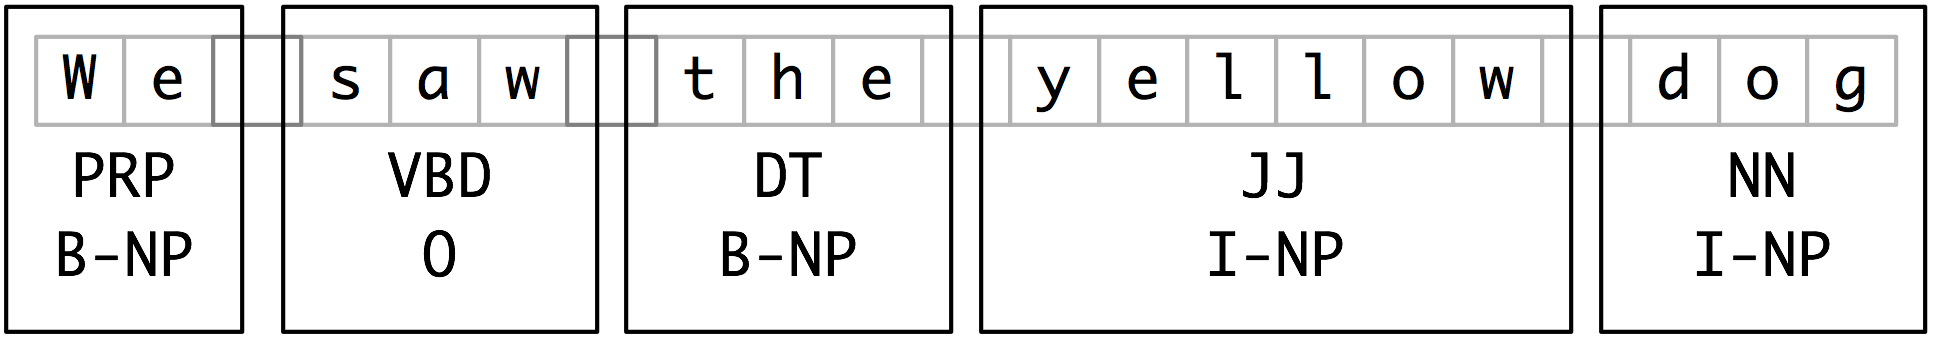

图 2.5：词块结构的标记表示形式

IOB标记已成为文件中表示词块结构的标准方式，我们也将使用这种格式。下面是[2.5](https://usyiyi.github.io/nlp-py-2e-zh/7.html#fig-chunk-tagrep)中的信息如何出现在一个文件中的：


> We PRP B-NP
> 
> saw VBD O
> 
> the DT B-NP
> 
> yellow JJ I-NP
> 
> dog NN I-NP

注意

NLTK使用树作为词块的内部表示，并提供这些树与IOB格式互换的方法。

## 3 开发和评估词块划分器

现在你对分块的作用有了一些了解，但我们并没有解释如何评估词块划分器。和往常一样，这需要一个合适的已标注语料库。我们一开始寻找将IOB格式转换成NLTK树的机制，然后是使用已化分词块的语料库如何在一个更大的规模上做这个。我们将看到如何为一个词块划分器相对一个语料库的准确性打分，再看看一些数据驱动方式搜索NP词块。我们整个的重点在于扩展一个词块划分器的覆盖范围。

jupyter notebook

<a href="#3.1-读取IOB格式与CoNLL2000语料库">3.1 读取IOB格式与CoNLL2000语料库</a> 

<a href="#3.2-简单的评估和基准">3.2 简单的评估和基准</a> 

<a href="#3.3-训练基于分类器的词块划分器">3.3 训练基于分类器的词块划分器</a> 

vscode jupyter

<a href="#31-读取IOB格式与CoNLL2000语料库">3.1 读取IOB格式与CoNLL2000语料库</a> 

<a href="#32-简单的评估和基准">3.2 简单的评估和基准</a> 

<a href="#33-训练基于分类器的词块划分器">3.3 训练基于分类器的词块划分器</a> 

## 3.1 读取IOB格式与CoNLL2000语料库

使用`corpus`模块，我们可以加载已经标注并使用IOB符号划分词块的《华尔街日报》文本。这个语料库提供的词块类型有`NP`，`VP`和`PP`。正如我们已经看到的，每个句子使用多行表示，如下所示：

> he PRP B-NP
> 
> accepted VBD B-VP
> 
> the DT B-NP
> 
> position NN I-NP



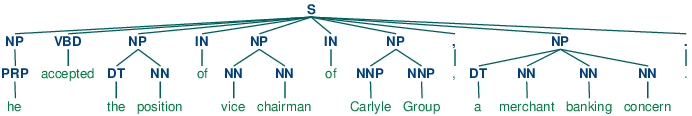

我们可以使用NLTK的corpus模块访问较大量的已经划分词块的文本。CoNLL2000语料库包含27万词的《华尔街日报文本》，分为“训练”和“测试”两部分，标注有词性标记和IOB格式词块标记。我们可以使用`nltk.corpus.conll2000`访问这些数据。下面是一个读取语料库的“训练”部分的第100个句子的例子：

In [9]:
from nltk.corpus import conll2000
print(conll2000.chunked_sents('train.txt')[99])

(S
  (PP Over/IN)
  (NP a/DT cup/NN)
  (PP of/IN)
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  (VP told/VBD)
  (NP his/PRP$ story/NN)
  ./.)


正如你看到的，CoNLL2000语料库包含三种词块类型：`NP`词块，我们已经看到了；`VP`词块如has already delivered；`PP`块如because of。因为现在我们唯一感兴趣的是`NP`词块，我们可以使用`chunk_types`参数选择它们：

In [10]:
print(conll2000.chunked_sents('train.txt', chunk_types=['NP'])[99])

(S
  Over/IN
  (NP a/DT cup/NN)
  of/IN
  (NP coffee/NN)
  ,/,
  (NP Mr./NNP Stone/NNP)
  told/VBD
  (NP his/PRP$ story/NN)
  ./.)


## 3.2 简单的评估和基准

现在，我们可以访问一个已划分词块语料，可以评估词块划分器。我们开始为没有什么意义的词块解析器`cp`建立一个基准，它不划分任何词块：

In [14]:
from nltk.corpus import conll2000

cp = nltk.RegexpParser("")
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
# print(cp.evaluate(test_sents)) # evaluate函数已弃用，请使用accuracy函数
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  43.4%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


IOB标记准确性表明超过三分之一的词被标注为`O`，即没有在`NP`词块中。然而，由于我们的标注器没有找到*任何*词块，其精度、召回率和F-度量均为零。现在让我们尝试一个初级的正则表达式词块划分器，查找以名词短语标记的特征字母开头的标记（如`CD`, `DT`和`JJ`）。

In [16]:
grammar = r"NP: {<[CDJNP].*>+}"
cp = nltk.RegexpParser(grammar)
# print(cp.evaluate(test_sents))
print(cp.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  87.7%%
    Precision:     70.6%%
    Recall:        67.8%%
    F-Measure:     69.2%%


正如你看到的，这种方法达到相当好的结果。但是，我们可以采用更多数据驱动的方法改善它，在这里我们使用训练语料找到对每个词性标记最有可能的块标记（`I`, `O`或`B`）。换句话说，我们可以使用*一元标注器*（[4](https://usyiyi.github.io/nlp-py-2e-zh/5.html#sec-automatic-tagging)）建立一个词块划分器。但不是尝试确定每个词的正确的词性标记，而是根据每个词的词性标记，尝试确定正确的词块标记。

在[3.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker)中，我们定义了`UnigramChunker`类，使用一元标注器给句子加词块标记。这个类的大部分代码只是用来在NLTK 的`ChunkParserI`接口使用的词块树表示和嵌入式标注器使用的IOB表示之间镜像转换。类定义了两个方法：一个构造函数 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker-constructor)，当我们建立一个新的UnigramChunker时调用；以及`parse`方法 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker-parse)，用来给新句子划分词块。

In [17]:
class UnigramChunker(nltk.ChunkParserI):
    def __init__(self, train_sents): 
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)]
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data) 

    def parse(self, sentence): 
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        conlltags = [(word, pos, chunktag) for ((word,pos),chunktag)
                     in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)

构造函数 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker-constructor)需要训练句子的一个列表，这将是词块树的形式。它首先将训练数据转换成适合训练标注器的形式，使用`tree2conlltags`映射每个词块树到一个`word,tag,chunk`三元组的列表。然后使用转换好的训练数据训练一个一元标注器，并存储在`self.tagger`供以后使用。

`parse`方法 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker-parse)接收一个已标注的句子作为其输入，以从那句话提取词性标记开始。它然后使用在构造函数中训练过的标注器`self.tagger`，为词性标记标注IOB词块标记。接下来，它提取词块标记，与原句组合，产生`conlltags`。最后，它使用`conlltags2tree`将结果转换成一个词块树。

现在我们有了`UnigramChunker`，可以使用CoNLL2000语料库训练它，并测试其表现：

In [19]:
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])
train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
unigram_chunker = UnigramChunker(train_sents)
# print(unigram_chunker.evaluate(test_sents))
print(unigram_chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


这个分块器相当不错，达到整体F-度量83％的得分。让我们来看一看通过使用一元标注器分配一个标记给每个语料库中出现的词性标记，它学到了什么：

In [20]:
postags = sorted(set(pos for sent in train_sents
                     for (word,pos) in sent.leaves()))
print(unigram_chunker.tagger.tag(postags))

[('#', 'B-NP'), ('$', 'B-NP'), ("''", 'O'), ('(', 'O'), (')', 'O'), (',', 'O'), ('.', 'O'), (':', 'O'), ('CC', 'O'), ('CD', 'I-NP'), ('DT', 'B-NP'), ('EX', 'B-NP'), ('FW', 'I-NP'), ('IN', 'O'), ('JJ', 'I-NP'), ('JJR', 'B-NP'), ('JJS', 'I-NP'), ('MD', 'O'), ('NN', 'I-NP'), ('NNP', 'I-NP'), ('NNPS', 'I-NP'), ('NNS', 'I-NP'), ('PDT', 'B-NP'), ('POS', 'B-NP'), ('PRP', 'B-NP'), ('PRP$', 'B-NP'), ('RB', 'O'), ('RBR', 'O'), ('RBS', 'B-NP'), ('RP', 'O'), ('SYM', 'O'), ('TO', 'O'), ('UH', 'O'), ('VB', 'O'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'B-NP'), ('WP', 'B-NP'), ('WP$', 'B-NP'), ('WRB', 'O'), ('``', 'O')]


它已经发现大多数标点符号出现在NP词块外，除了两种货币符号`#`和`$`。它也发现限定词（`DT`）和所有格（`PRP$`和`WP$`）出现在NP词块的开头，而名词类型(`NN`, `NNP`, `NNPS`，`NNS`)大多出现在NP词块内。

建立了一个一元分块器，很容易建立一个二元分块器：我们只需要改变类的名称为`BigramChunker`，修改[3.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker)行 [# 2](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-unigram-chunker-buildit)构造一个`BigramTagger`而不是`UnigramTagger`。由此产生的词块划分器的性能略高于一元词块划分器：

In [23]:
#建立bigram分类器
class BigramChunker(nltk.ChunkParserI): # 参考：https://www.cnblogs.com/nxf-rabbit75/p/9565176.html
    def __init__(self,train_sents):
        train_data = [[(t,c) for w,t,c in nltk.chunk.tree2conlltags(sent)] for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)

    def parse(self, sentence):
        pos_tags = [pos for (word,pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos,chunktag) in tagged_pos_tags]

        #为词性标注IOB块标记
        conlltags = [(word,pos,chunktag) for ((word,pos),chunktag) in zip(sentence,chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)#转化成分块树状图

In [25]:
bigram_chunker = BigramChunker(train_sents)
# print(bigram_chunker.evaluate(test_sents))
print(bigram_chunker.accuracy(test_sents))

ChunkParse score:
    IOB Accuracy:  93.3%%
    Precision:     82.3%%
    Recall:        86.8%%
    F-Measure:     84.5%%


## 3.3 训练基于分类器的词块划分器

无论是基于正则表达式的词块划分器还是n-gram词块划分器，决定创建什么词块完全基于词性标记。然而，有时词性标记不足以确定一个句子应如何划分词块。例如，考虑下面的两个语句：

In [16]:
import nltk
# nltk.download('conll2000') # 如果报错没有这个数据集则需要下载
# nltk.config_megam("./megam-64.opt") # Linux 指定 megam 所在目录

class ConsecutiveNPChunkTagger(nltk.TaggerI): # [1]

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) # [2]
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.MaxentClassifier.train( # [3]
            train_set, algorithm='iis', trace=0) # Linux: algorithm="megam" 使用默认 iss 算法替换

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): # [4]
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

<!--以下是 megam 的源代码网址和 ocaml 编译器网址：-->

<a href="http://users.umiacs.umd.edu/~hal/megam/index.html"></a>

<a href="# nltk.config_megam('D:/nltk_data/megam-64.opt') # 在使用 megam 时设置位置（Linux)"></a>
<a href="# nltk.config_megam('D:/nltk_data/megam.exe') # 在使用 megam 时设置位置（Windows)"></a>

<a href="https://github.com/rjafarau/nltk-book"></a>

<a href="http://fdopen.github.io/opam-repository-mingw/installation/"></a>

留下来唯一需要填写的是特征提取器。首先，我们定义一个简单的特征提取器，它只是提供了当前词符的词性标记。使用此特征提取器，我们的基于分类器的词块划分器的表现与一元词块划分器非常类似：

In [14]:
from nltk.corpus import conll2000

train_sents = conll2000.chunked_sents('train.txt', chunk_types=['NP'])
test_sents = conll2000.chunked_sents('test.txt', chunk_types=['NP'])

In [17]:
def npchunk_features(sentence, i, history):
    # print("sentence:", sentence)
    # print("i:", i)
    # print("history:", history)
    word, pos = sentence[i]
    return {"pos": pos}
chunker = ConsecutiveNPChunker(train_sents) # 这几个代码块可在运行半分钟后手动停止来显示结果，完整运行所需时间大于10分钟
# print(chunker.evaluate(test_sents))
print(chunker.accuracy(test_sents))

      Training stopped: keyboard interrupt
ChunkParse score:
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%


<!-- py文件运行结果记录
(nltk38) D:\NLP-3b>python 7.py
ChunkParse score:        
    IOB Accuracy:  92.9%%
    Precision:     79.9%%
    Recall:        86.8%%
    F-Measure:     83.2%%
耗时: 632.02秒 -->

我们还可以添加一个特征表示前面词的词性标记。添加此特征允许词块划分器模拟相邻标记之间的相互作用，由此产生的词块划分器与二元词块划分器非常接近。

In [19]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "prevpos": prevpos}
chunker = ConsecutiveNPChunker(train_sents)
# print(chunker.evaluate(test_sents))
print(chunker.accuracy(test_sents))

      Training stopped: keyboard interrupt
ChunkParse score:
    IOB Accuracy:  93.5%%
    Precision:     82.2%%
    Recall:        87.4%%
    F-Measure:     84.8%%


下一步，我们将尝试为当前词增加特征，因为我们假设这个词的内容应该对词块划有用。我们发现这个特征确实提高了词块划分器的表现，大约1.5个百分点（相应的错误率减少大约10％）。

In [20]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    return {"pos": pos, "word": word, "prevpos": prevpos}
chunker = ConsecutiveNPChunker(train_sents)
# print(chunker.evaluate(test_sents))
print(chunker.accuracy(test_sents))

      Training stopped: keyboard interrupt
ChunkParse score:
    IOB Accuracy:  94.4%%
    Precision:     84.7%%
    Recall:        89.5%%
    F-Measure:     87.0%%


最后，我们尝试用多种附加特征扩展特征提取器，例如预取特征  [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#chunk-fe-lookahead)、配对特征  [# 2](https://usyiyi.github.io/nlp-py-2e-zh/7.html#chunk-fe-paired)和复杂的语境特征 [# 3](https://usyiyi.github.io/nlp-py-2e-zh/7.html#chunk-fe-complex)。这最后一个特征，称为`tags-since-dt`，创建一个字符串，描述自最近的限定词以来遇到的所有词性标记，或如果没有限定词则在索引`i`之前自语句开始以来遇到的所有词性标记。

In [21]:
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
    if i == len(sentence)-1:
        nextword, nextpos = "<END>", "<END>"
    else:
        nextword, nextpos = sentence[i+1]
    return {"pos": pos,
            "word": word,
            "prevpos": prevpos,
            "nextpos": nextpos, 
            "prevpos+pos": "%s+%s" % (prevpos, pos),  
            "pos+nextpos": "%s+%s" % (pos, nextpos),
            "tags-since-dt": tags_since_dt(sentence, i)}  
def tags_since_dt(sentence, i):
    tags = set()
    for word, pos in sentence[:i]:
        if pos == 'DT':
            tags = set()
        else:
            tags.add(pos)
    return '+'.join(sorted(tags))
chunker = ConsecutiveNPChunker(train_sents)
# print(chunker.evaluate(test_sents))
print(chunker.accuracy(test_sents))

      Training stopped: keyboard interrupt
ChunkParse score:
    IOB Accuracy:  94.8%%
    Precision:     86.4%%
    Recall:        89.6%%
    F-Measure:     87.9%%


注意

**轮到你来：**尝试为特征提取器函数`npchunk_features`增加不同的特征，看看是否可以进一步改善NP词块划分器的表现。

## 4 语言结构中的递归

jupyter notebook

<a href="#4.1-用级联词块划分器构建嵌套结构">4.1 用级联词块划分器构建嵌套结构</a> 

<a href="#4.2-Trees">4.2 Trees</a> 

<a href="#4.3-树遍历">4.3 树遍历</a> 

vscode jupyter

<a href="#41-用级联词块划分器构建嵌套结构">4.1 用级联词块划分器构建嵌套结构</a> 

<a href="#42-Trees">4.2 Trees</a> 

<a href="#43-树遍历">4.3 树遍历</a> 

## 4.1 用级联词块划分器构建嵌套结构

到目前为止，我们的词块结构一直是相对平的。已标注词符组成的树在如`NP`这样的词块节点下任意组合。然而，只需创建一个包含递归规则的多级的词块语法，就可以建立任意深度的词块结构。[4.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-cascaded-chunker)是名词短语、介词短语、动词短语和句子的模式。这是一个四级词块语法器，可以用来创建深度最多为4的结构。

In [46]:
grammar = r"""
  NP: {<DT|JJ|NN.*>+}          # Chunk sequences of DT, JJ, NN
  PP: {<IN><NP>}               # Chunk prepositions followed by NP
  VP: {<VB.*><NP|PP|CLAUSE>+$} # Chunk verbs and their arguments
  CLAUSE: {<NP><VP>}           # Chunk NP, VP
  """
cp = nltk.RegexpParser(grammar)
sentence = [("Mary", "NN"), ("saw", "VBD"), ("the", "DT"), ("cat", "NN"),
    ("sit", "VB"), ("on", "IN"), ("the", "DT"), ("mat", "NN")]

不幸的是，这一结果丢掉了saw为首的`VP`。它还有其他缺陷。当我们将此词块划分器应用到一个有更深嵌套的句子时，让我们看看会发生什么。请注意，它无法识别 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#saw-vbd)开始的`VP`词块。

In [47]:
sentence = [("John", "NNP"), ("thinks", "VBZ"), ("Mary", "NN"),
    ("saw", "VBD"), ("the", "DT"), ("cat", "NN"), ("sit", "VB"),
    ("on", "IN"), ("the", "DT"), ("mat", "NN")]
print(cp.parse(sentence))

(S
  (NP John/NNP)
  thinks/VBZ
  (NP Mary/NN)
  saw/VBD
  (CLAUSE
    (NP the/DT cat/NN)
    (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))


这些问题的解决方案是让词块划分器在它的模式中循环：尝试完所有模式之后，重复此过程。我们添加一个可选的第二个参数`loop`指定这套模式应该循环的次数：

In [48]:
cp = nltk.RegexpParser(grammar, loop=2)
print(cp.parse(sentence))

(S
  (NP John/NNP)
  thinks/VBZ
  (CLAUSE
    (NP Mary/NN)
    (VP
      saw/VBD
      (CLAUSE
        (NP the/DT cat/NN)
        (VP sit/VB (PP on/IN (NP the/DT mat/NN)))))))


注意

这个级联过程使我们能创建深层结构。然而，创建和调试级联过程是困难的，关键点是它能更有效地做全面的分析（见第[8.](https://usyiyi.github.io/nlp-py-2e-zh/8.html#chap-parse)章）。另外，级联过程只能产生固定深度的树（不超过级联级数），完整的句法分析这是不够的。

## 4.2 Trees

tree是一组连接的加标签节点，从一个特殊的根节点沿一条唯一的路径到达每个节点。下面是一棵树的例子（注意它们标准的画法是颠倒的）：

> (S
>
>   (NP Alice)
>
>   (VP
>
>      (V chased)
>
>      (NP
>
>         (Det the)
>
>         (N rabbit))))


虽然我们将只集中关注语法树，树可以用来编码任何同构的超越语言形式序列的层次结构（如形态结构、篇章结构）。一般情况下，叶子和节点值不一定要是字符串。

在NLTK中，我们通过给一个节点添加标签和一系列的孩子创建一棵树：

In [49]:
tree1 = nltk.Tree('NP', ['Alice'])
print(tree1)

(NP Alice)


In [50]:
tree2 = nltk.Tree('NP', ['the', 'rabbit'])
print(tree2)

(NP the rabbit)


我们可以将这些不断合并成更大的树，如下所示：

In [51]:
tree3 = nltk.Tree('VP', ['chased', tree2])
tree4 = nltk.Tree('S', [tree1, tree3])
print(tree4)

(S (NP Alice) (VP chased (NP the rabbit)))


下面是树对象的一些的方法：

In [53]:
print(tree4[1])

(VP chased (NP the rabbit))


In [54]:
tree4[1].label()

'VP'

In [55]:
tree4.leaves()

['Alice', 'chased', 'the', 'rabbit']

In [56]:
tree4[1][1][1]

'rabbit'

复杂的树用括号表示难以阅读。在这些情况下，`draw`方法是非常有用的。它会打开一个新窗口，包含树的一个图形表示。树显示窗口可以放大和缩小，子树可以折叠和展开，并将图形表示输出为一个postscript文件（包含在一个文档中）。

In [60]:
tree3.draw()

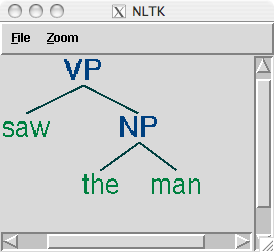

## 4.3 树遍历

使用递归函数来遍历树是标准的做法。[4.2](https://usyiyi.github.io/nlp-py-2e-zh/7.html#code-traverse)中的内容进行了演示。

In [89]:
def traverse(t):
    try:
        t.label()
    except AttributeError:
        print(t, end=" ")
    else:
        # Now we know that t.node is defined
        print('(', t.label(), end=" ")
        for child in t:
            traverse(child)
        print(')', end=" ")

# t = nltk.Tree('(S (NP Alice) (VP chased (NP the rabbit)))')
# https://stackoverflow.com/questions/26913134/parentedtree-expected-a-node-value-and-child-list-or-a-single-string-or-parent
t = nltk.Tree.fromstring('(S (NP Alice) (VP chased (NP the rabbit)))')
traverse(t)

( S ( NP Alice ) ( VP chased ( NP the rabbit ) ) ) 

注意

我们已经使用了一种叫做动态类型的技术，检测`t`是一棵树（如定义了`t.label()`）。

## 5 命名实体识别

在本章开头，我们简要介绍了命名实体（NE）。命名实体是确切的名词短语，指示特定类型的个体，如组织、人、日期等。[5.1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#tab-ne-types)列出了一些较常用的NE类型。这些应该是不言自明的，除了“FACILITY”：建筑和土木工程领域的人造产品；以及“GPE”：地缘政治实体，如城市、州/省、国家。

表 5.1：

常用命名实体类型

> Eddy N B-PER
> 
> Bonte N I-PER
> 
> is V O
> 
> woordvoerder N O
> 
> van Prep O
> 
> diezelfde Pron O
> 
> Hogeschool N B-ORG
> 
> . Punc O

In [64]:
print(nltk.ne_chunk(sent)) 

(S
  From/IN
  what/WDT
  I/PPSS
  was/BEDZ
  able/JJ
  to/IN
  gauge/NN
  in/IN
  a/AT
  swift/JJ
  ,/,
  greedy/JJ
  glance/NN
  ,/,
  the/AT
  figure/NN
  inside/IN
  the/AT
  coral-colored/JJ
  boucle/NN
  dress/NN
  was/BEDZ
  stupefying/VBG
  ./.)


## 6 关系抽取

一旦文本中的命名实体已被识别，我们就可以提取它们之间存在的关系。如前所述，我们通常会寻找指定类型的命名实体之间的关系。进行这一任务的方法之一是首先寻找所有*X*, α, *Y*)形式的三元组，其中*X*和*Y*是指定类型的命名实体，α表示*X*和*Y*之间关系的字符串。然后我们可以使用正则表达式从α的实体中抽出我们正在查找的关系。下面的例子搜索包含词in的字符串。特殊的正则表达式`(?!\b.+ing\b)`是一个否定预测先行断言，允许我们忽略如success in supervising the transition of中的字符串，其中in后面跟一个动名词。

In [66]:
import re

IN = re.compile(r'.*\bin\b(?!\b.+ing)')
for doc in nltk.corpus.ieer.parsed_docs('NYT_19980315'):
    for rel in nltk.sem.extract_rels('ORG', 'LOC', doc,
                                     corpus='ieer', pattern = IN):
        print(nltk.sem.rtuple(rel))

[ORG: 'WHYY'] 'in' [LOC: 'Philadelphia']
[ORG: 'McGlashan &AMP; Sarrail'] 'firm in' [LOC: 'San Mateo']
[ORG: 'Freedom Forum'] 'in' [LOC: 'Arlington']
[ORG: 'Brookings Institution'] ', the research group in' [LOC: 'Washington']
[ORG: 'Idealab'] ', a self-described business incubator based in' [LOC: 'Los Angeles']
[ORG: 'Open Text'] ', based in' [LOC: 'Waterloo']
[ORG: 'WGBH'] 'in' [LOC: 'Boston']
[ORG: 'Bastille Opera'] 'in' [LOC: 'Paris']
[ORG: 'Omnicom'] 'in' [LOC: 'New York']
[ORG: 'DDB Needham'] 'in' [LOC: 'New York']
[ORG: 'Kaplan Thaler Group'] 'in' [LOC: 'New York']
[ORG: 'BBDO South'] 'in' [LOC: 'Atlanta']
[ORG: 'Georgia-Pacific'] 'in' [LOC: 'Atlanta']


搜索关键字in执行的相当不错，虽然它的检索结果也会误报，例如`[ORG: House Transportation Committee] , secured the most money in the [LOC: New York]`；一种简单的基于字符串的方法排除这样的填充字符串似乎不太可能。

如前文所示，`conll2002`命名实体语料库的荷兰语部分不只包含命名实体标注，也包含词性标注。这允许我们设计对这些标记敏感的模式，如下面的例子所示。`clause()`方法以分条形式输出关系，其中二元关系符号作为参数`relsym`的值被指定 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#relsym)。

In [67]:
from nltk.corpus import conll2002
vnv = """
(
is/V|    # 3rd sing present and
was/V|   # past forms of the verb zijn ('be')
werd/V|  # and also present
wordt/V  # past of worden ('become)
)
.*       # followed by anything
van/Prep # followed by van ('of')
"""
VAN = re.compile(vnv, re.VERBOSE)
for doc in conll2002.chunked_sents('ned.train'):
    for r in nltk.sem.extract_rels('PER', 'ORG', doc,
                                   corpus='conll2002', pattern=VAN):
        print(nltk.sem.clause(r, relsym="VAN")) 

VAN("cornet_d'elzius", 'buitenlandse_handel')
VAN('johan_rottiers', 'kardinaal_van_roey_instituut')
VAN('annie_lennox', 'eurythmics')


注意

**轮到你来：**替换最后一行 [# 1](https://usyiyi.github.io/nlp-py-2e-zh/7.html#relsym)为`print(rtuple(rel, lcon=True, rcon=True))`。这将显示实际的词表示两个NE之间关系以及它们左右的默认10个词的窗口的上下文。在一本荷兰语词典的帮助下，你也许能够找出为什么结果`VAN('annie_lennox', 'eurythmics')`是个误报。

## 7 小结

- 信息提取系统搜索大量非结构化文本，寻找特定类型的实体和关系，并用它们来填充有组织的数据库。这些数据库就可以用来寻找特定问题的答案。
- 信息提取系统的典型结构以断句开始，然后是分词和词性标注。接下来在产生的数据中搜索特定类型的实体。最后，信息提取系统着眼于文本中提到的相互临近的实体，并试图确定这些实体之间是否有指定的关系。
- 实体识别通常采用词块划分器，它分割多词符序列，并用适当的实体类型给它们加标签。常见的实体类型包括组织、人员、地点、日期、时间、货币、GPE（地缘政治实体）。
- 用基于规则的系统可以构建词块划分器，例如NLTK中提供的`RegexpParser`类；或使用机器学习技术，如本章介绍的`ConsecutiveNPChunker`。在这两种情况中，词性标记往往是搜索词块时的一个非常重要的特征。
- 虽然词块划分器专门用来建立相对平坦的数据结构，其中没有任何两个词块允许重叠，但它们可以被串联在一起，建立嵌套结构。
- 关系抽取可以使用基于规则的系统，它通常查找文本中的连结实体和相关的词的特定模式；或使用机器学习系统，通常尝试从训练语料自动学习这种模式。

## 8 深入阅读

本章的附加材料发布在`http://nltk.org/`，包括网络上免费提供的资源的链接。关于使用NLTK词块划分的更多的例子，请看在`http://nltk.org/howto`上的词块划分HOWTO。

分块的普及很大一部分是由于Abney的开创性的工作，如[(Church, Young, & Bloothooft, 1996)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#abney1996pst)。`http://www.vinartus.net/spa/97a.pdf`中描述了Abney的Cass词块划分器器。

根据Ross和Tukey在1975年的论文[(Church, Young, & Bloothooft, 1996)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#abney1996pst)，单词词缝最初的意思是一个停用词序列。

IOB格式（有时也称为BIO格式）由[(Ramshaw & Marcus, 1995)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#ramshaw1995tcu)开发用来`NP`划分词块，并被由*Conference on Natural Language Learning*在1999年用于`NP`加括号共享任务。CoNLL 2000采用相同的格式标注了华尔街日报的文本作为一个`NP`词块划分共享任务的一部分。

[(Jurafsky & Martin, 2008)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#jurafskymartin2008)的13.5节包含有关词块划分的一个讨论。第22 章讲述信息提取，包括命名实体识别。有关生物学和医学中的文本挖掘的信息，请参阅[(Ananiadou & McNaught, 2006)](https://usyiyi.github.io/nlp-py-2e-zh/bibliography.html#ananiadou2006)。

## 9 练习

1. ☼ IOB 格式分类标注标识符为`I`、`O`和`B`。三个标签为什么是必要的？如果我们只使用`I`和`O`标记会造成什么问题？

2. ☼ 写一个标记模式匹配包含复数中心名词在内的名词短语，如"many/JJ researchers/NNS", "two/CD weeks/NNS", "both/DT new/JJ positions/NNS"。通过泛化处理单数名词短语的标记模式，尝试做这个。

3. ☼ 选择CoNLL语料库中三种词块类型之一。研究CoNLL语料库，并尝试观察组成这种类型词块的词性标记序列的任何模式。使用正则表达式词块划分器`nltk.RegexpParser`开发一个简单的词块划分器。讨论任何难以可靠划分词块的标记序列。

4. ☼ *词块*的早期定义是出现在词缝之间的内容。开发一个词块划分器以将完整的句子作为一个单独的词块开始，然后其余的工作完全加塞词缝完成。在你自己的应用程序的帮助下，确定哪些标记（或标记序列）最有可能组成词缝。相对于完全基于词块规则的词块划分器，比较这种方法的表现和易用性。

5. ◑ 写一个标记模式，涵盖包含动名词在内的名词短语，如"the/DT receiving/VBG end/NN", "assistant/NN managing/VBG editor/NN"。将这些模式加入到语法，每行一个。用自己设计的一些已标注的句子，测试你的工作。

6. ◑ 写一个或多个标记模式处理有连接词的名词短语，如"July/NNP and/CC August/NNP", "all/DT your/PRP$ managers/NNS and/CC supervisors/NNS", "company/NN courts/NNS and/CC adjudicators/NNS"。

7. ◑ 用任何你之前已经开发的词块划分器执行下列评估任务。

   （请注意，大多数词块划分语料库包含一些内部的不一致，以至于任何合理的基于规则的方法都将产生错误。）

   1. 在来自词块划分语料库的100个句子上评估你的词块划分器，报告精度、召回率和F-量度。
   2. 使用`chunkscore.missed()`和`chunkscore.incorrect()`方法识别你的词块划分器的错误。讨论。
   3. 与本章的评估部分讨论的基准词块划分器比较你的词块划分器的表现。

8. ◑ 使用基于正则表达式的词块语法`RegexpChunk`，为CoNLL语料库中词块类型中的一个开发一个词块划分器。使用词块、词缝、合并或拆分规则的任意组合。

9. ◑ 有时一个词的标注不正确，例如"12/CD or/CC so/RB cases/VBZ"中的中心名词。不用要求手工校正标注器的输出，好的词块划分器使用标注器的错误输出也能运作。查找使用不正确的标记正确为名词短语划分词块的其他例子。

10. ◑ 二元词块划分器的准确性得分约为90％。研究它的错误，并试图找出它为什么不能获得100％的准确率。实验三元词块划分。你能够再提高准确性吗？

11. ★ 在IOB词块标注上应用n-gram和Brill标注方法。不是给词分配词性标记，在这里我们给词性标记分配IOB标记。例如如果标记`DT`（限定符）经常出现在一个词块的开头，它会被标注为`B`（开始）。相对于本章中讲到的正则表达式词块划分方法，评估这些词块划分方法的表现。

12. ★ 在[5.](https://usyiyi.github.io/nlp-py-2e-zh/5.html#chap-tag)中我们看到，通过查找有歧义的n-grams可以得到标注准确性的上限，即在训练数据中有多种可能的方式标注的n-grams。应用同样的方法来确定一个n-gram词块划分器的上限。

13. ★ 挑选CoNLL语料库中三种词块类型之一。

编写函数为你选择的类型做以下任务：

1. 列出与此词块类型的每个实例一起出现的所有标记序列。
2. 计数每个标记序列的频率，并产生一个按频率减少的顺序排列的列表；每行要包含一个整数（频率）和一个标记序列。
3. 检查高频标记序列。使用这些作为开发一个更好的词块划分器的基础。

14. ★ 在评估一节中提到的基准词块划分器往往会产生比它应该产生的块更大的词块。例如，短语`[every/DT time/NN] [she/PRP] sees/VBZ [a/DT newspaper/NN]`包含两个连续的词块，我们的基准词块划分器不正确地将前两个结合： `[every/DT time/NN she/PRP]`。写一个程序，找出这些通常出现在一个词块的开头的词块内部的标记有哪些，然后设计一个或多个规则分裂这些词块。将这些与现有的基准词块划分器组合，重新评估它，看看你是否已经发现了一个改进的基准。

15. ★ 开发一个`NP`词块划分器，转换POS标注文本为元组的一个列表，其中每个元组由一个后面跟一个名词短语和介词的动词组成，如`the little cat sat on the mat`变成`('sat', 'on', 'NP')`...

16. ★ 宾州树库样例包含一部分已标注的《华尔街日报》文本，已经按名词短语划分词块。

其格式使用方括号，我们已经在本章遇到它了几次。

该语料可以使用`for sent in nltk.corpus.treebank_chunk.chunked_sents(fileid)`来访问。

这些都是平坦的树，正如我们使用`nltk.corpus.conll2000.chunked_sents()`得到的一样。

1. 函数`nltk.tree.pprint()`和`nltk.chunk.tree2conllstr()`可以用来从一棵树创建树库和IOB字符串。编写函数`chunk2brackets()`和`chunk2iob()`，以一个单独的词块树为它们唯一的参数，返回所需的多行字符串表示。
2. 写命令行转换工具`bracket2iob.py`和`iob2bracket.py`，（分别）读取树库或CoNLL格式的一个文件，将它转换为其他格式。（从NLTK语料库获得一些原始的树库或CoNLL 数据，保存到一个文件，然后使用`for line in open(filename)`从Python访问它。）

17. ★ 一个n-gram词块划分器可以使用除当前词性标记和n-1个前面的词块的标记以外其他信息。调查其他的上下文模型，如n-1个前面的词性标记，或一个写前面词块标记连同前面和后面的词性标记的组合。

18. ★ 思考一个n-gram标注器使用临近的标记的方式。现在观察一个词块划分器可能如何重新使用这个序列信息。例如：这两个任务将使用名词往往跟在形容词后面（英文中）的信息。这会出现相同的信息被保存在两个地方的情况。随着规则集规模增长，这会成为一个问题吗？如果是，推测可能会解决这个问题的任何方式。

关于本文档...

针对NLTK 3.0 作出更新。本章来自于*Natural Language Processing with Python*，[Steven Bird](http://estive.net/), [Ewan Klein](http://homepages.inf.ed.ac.uk/ewan/) 和[Edward Loper](http://ed.loper.org/)，Copyright © 2014 作者所有。本章依据*Creative Commons Attribution-Noncommercial-No Derivative Works 3.0 United States License* [http://creativecommons.org/licenses/by-nc-nd/3.0/us/] 条款，与*自然语言工具包* [`http://nltk.org/`] 3.0 版一起发行。

本文档构建于星期三 2015 年 7 月 1 日 12:30:05 AEST